# Evaluation -- Visual Correctness

In [2]:
from PIL import Image
import numpy as np
from IPython.display import display

## Naive Encoding

Compress the value and store it in an image channel. 

Good for visual debugging, but not precise.

In [3]:
def process_image_red_component(image_path, max_value):
    # Load the image
    img = Image.open(image_path)
    img_array = np.array(img)

    # Extract the red component, scale it, and multiply by max_value
    red_component = img_array[:, :, 0] / 255 * max_value

    # Calculate the average
    average_red = np.mean(red_component)
    return average_red

In [4]:
eval_path = r"C:\Users\user\Documents\George\CPP_Projects\Procedural_Implicit_Terrain_Raymarching\Images\Eval"
image_names = [
    "eval_test",
    "eval_test_bs4"
]
quantity_name = "Ray March Precision"

for image_name in image_names:
    image_path = f"{eval_path}\\{image_name}.png"
    average_red = process_image_red_component(image_path, 100)
    print(f"{quantity_name} for {image_name}: {average_red}")


Ray March Precision for eval_test: 2.4886300957650773
Ray March Precision for eval_test_bs4: 0.48355977339032485


## Decode

Decode every vec4 (RGBA) as a float. 

In [5]:
def decode(png_file_path):
    # Load the image using PIL
    img = Image.open(png_file_path)
    # Convert the image to RGBA (in case it's not)
    img_rgba = img.convert("RGBA")

    # Convert the image to a numpy array
    data = np.array(img_rgba, dtype=np.uint32)

    # Perform the equivalent operation of the GLSL function
    # Shift and combine RGBA components
    ivalue = (data[:, :, 0] |
              (data[:, :, 1] << 8) |
              (data[:, :, 2] << 16) |
              (data[:, :, 3] << 24))

    # Interpret the integer bits as floats
    floats = np.frombuffer(ivalue.tobytes(), dtype=np.float32)
    floats = floats.reshape(ivalue.shape)

    return floats

Turn decoded values back to an image using the naive visual encoding, to make sure the encoding is correct:

In [8]:
def decoded_IDE_to_image(float_matrix):
    # Initialize an empty image with the same dimensions and RGBA format
    img_data = np.zeros((float_matrix.shape[0], float_matrix.shape[1], 4), dtype=np.uint8)

    # Iterate over each element in the float matrix
    for i in range(float_matrix.shape[0]):
        for j in range(float_matrix.shape[1]):
            value = float_matrix[i, j]

            # Handling edge cases
            if value == -100:
                # Blue color for -100
                img_data[i, j] = [0, 0, 255, 255]  # RGBA
            elif value == -1:
                # Red color for -1
                img_data[i, j] = [255, 0, 0, 255]  # RGBA
            else:
                # Normal case: scale by 1/1000
                scaled_value = int(min(max(value / 1000, 0), 1) * 255)
                img_data[i, j] = [scaled_value, scaled_value, scaled_value, 255]  # RGBA

    # Create an image from the numpy array
    img = Image.fromarray(img_data, 'RGBA')
    return img

In [9]:
image_path = f"{eval_path}\\encoded.png"
decoded = decode(image_path)

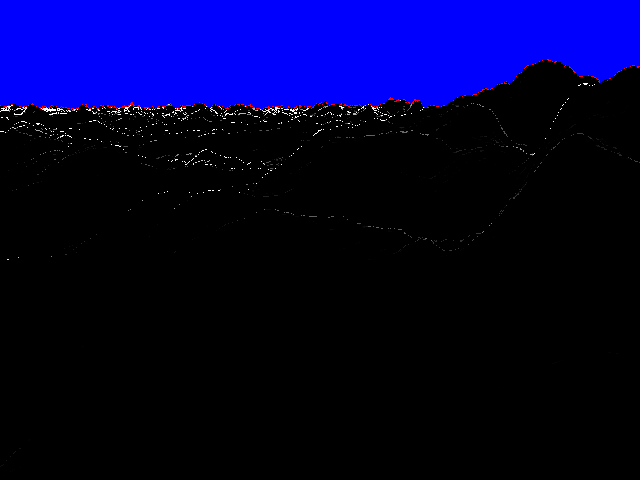

In [12]:
image = decoded_IDE_to_image(decoded)
image

## Intersection Distance Error (IDE)

In [23]:
image_path = f"{eval_path}\\encoded.png"
decoded = decode(image_path)

total_pixels = decoded.size

# count the number of -1 and -100 values
num_no_intersection = np.sum(decoded == -1)
num_no_intersection = np.sum(decoded == -100)

# average the positive values
positive_values = decoded[decoded > 0]
average_IDE = np.mean(positive_values)
highest_value = np.max(positive_values)
lowest_value = np.min(positive_values)

print((
    f"Among {total_pixels} pixels:\n"
    f"Number of missed intersections (-1): {num_no_intersection}\n"
    f"Number of no intersections (-100): {num_no_intersection}\n"
    f"Average IDE value: {average_IDE}\n"
    f"Lowest IDE value: {lowest_value}\n"
    f"Highest IDE value: {highest_value}"
))

Among 307200 pixels:
Number of missed intersections (-1): 475
Number of no intersections (-100): 61934
Average IDE value: 36.72679138183594
Lowest IDE value: 6.103515625e-05
Highest IDE value: 70548.4609375


Test whether the encoding is correct:

Number of red pixels: 475


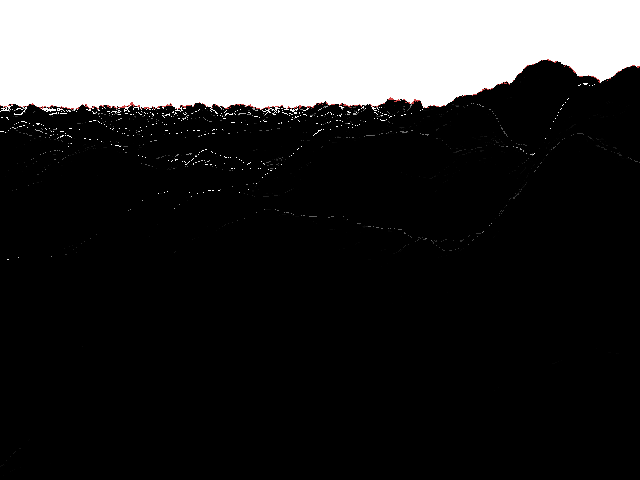

In [25]:
image_path = f"{eval_path}\\visual.png"
img = Image.open(image_path)
img_rgba = img.convert("RGBA")
data = np.array(img_rgba, dtype=np.uint32)

# count number of purely red pixels, no green, no blue
num_red_pixels = np.sum((data[:, :, 0] == 208) & (data[:, :, 1] == 70) & (data[:, :, 2] == 70))
print(f"Number of red pixels: {num_red_pixels}")
img

## Height Difference Error

In [42]:
def decoded_HDE_to_image(float_matrix):
    # Initialize an empty image with the same dimensions and RGBA format
    img_data = np.zeros((float_matrix.shape[0], float_matrix.shape[1], 4), dtype=np.uint8)

    # Iterate over each element in the float matrix
    for i in range(float_matrix.shape[0]):
        for j in range(float_matrix.shape[1]):
            value = float_matrix[i, j]

            # Handling edge cases
            if value == -1:
                # Red color for -1
                img_data[i, j] = [0, 0, 255, 255]  # RGBA
            else:
                # Normal case: scale by 1/1000
                scaled_value = int(min(max(value / 10, 0), 1) * 255)
                img_data[i, j] = [scaled_value, scaled_value, scaled_value, 255]  # RGBA

    # Create an image from the numpy array
    img = Image.fromarray(img_data, 'RGBA')
    return img

In [45]:
def HDE(image_name):
    image_path = f"{eval_path}\\{image_name}.png"
    decoded = decode(image_path)

    total_pixels = decoded.size

    # count the number of -1 and -100 values
    num_no_intersection = np.sum(decoded == -1)

    # average the positive values
    positive_values = decoded[decoded > 0]
    average_HDE = np.mean(positive_values)
    highest_value = np.max(positive_values)
    lowest_value = np.min(positive_values)

    print((
        f"For {image_name}:\n"
        f"\tAmong {total_pixels} pixels:\n"
        f"\tNumber of no intersections: {num_no_intersection}\n"
        f"\tAverage HDE value: {average_HDE}\n"
        f"\tLowest HDE value: {lowest_value}\n"
        f"\tHighest HDE value: {highest_value}"
    ))

    decoded_image = decoded_HDE_to_image(decoded)
    display(decoded_image)

For HDE_20240409_230924:
	Among 307200 pixels:
	Number of no intersections: 62022
	Average HDE value: 0.3034653961658478
	Lowest HDE value: 4.836463745050423e-07
	Highest HDE value: 95.49180603027344


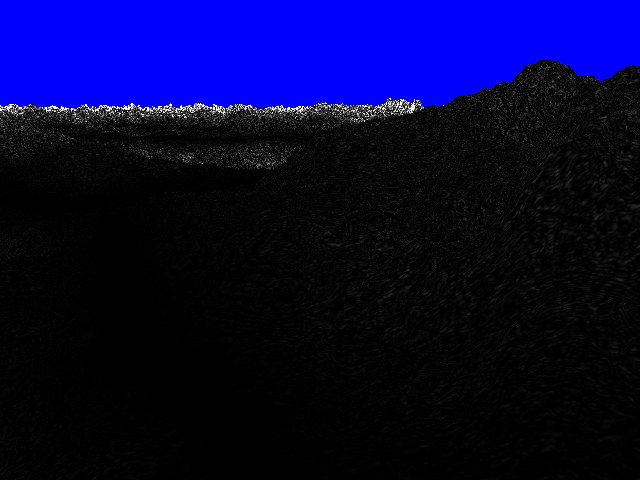

For HDE_20240409_232514:
	Among 307200 pixels:
	Number of no intersections: 62022
	Average HDE value: 0.0026891243178397417
	Lowest HDE value: 1.1548763723112643e-08
	Highest HDE value: 0.050390925258398056


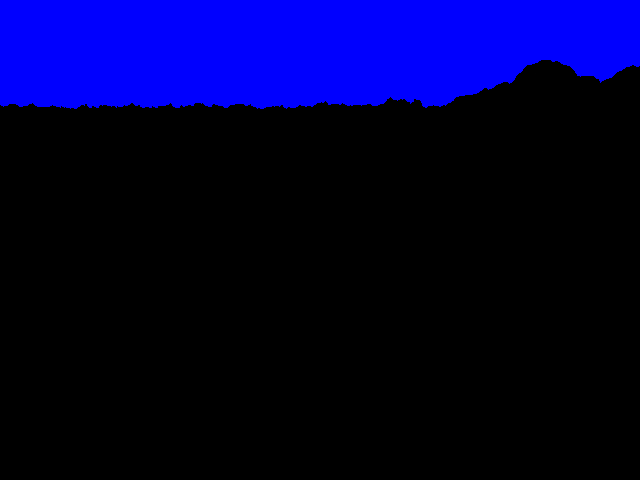

In [46]:
hde_files = [
    "HDE_20240409_230924", # BS 0
    "HDE_20240409_232514" # BS 12
]

for hde_file in hde_files:
    HDE(hde_file)
    image_path = f"{eval_path}\\{hde_file}.png"
    decoded = decode(image_path)
    image = decoded_HDE_to_image(decoded)